In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot
import scipy.sparse as sps

data_file_path = 'data_train.csv'
URM_all_dataframe = pd.read_csv(filepath_or_buffer=data_file_path,
                                sep=',',
                                engine='python')
URM_all_dataframe.columns = ['UserID', 'ItemID', 'Data']
URM_all_dataframe.head()


,UserID,ItemID,Data
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0


In [99]:
print("Number of items\t {}, Number of users\t {}".format(len(URM_all_dataframe['ItemID'].unique()), len(URM_all_dataframe['UserID'].unique())))
print("Number of interactions\t {}".format(URM_all_dataframe['Data'].count()))
print("Max value of UserID\t {}, Max value of ItemID\t {}".format(URM_all_dataframe['UserID'].max(), URM_all_dataframe['ItemID'].max()))

Number of items	 22222, Number of users	 12638
Number of interactions	 478730
Max value of UserID	 13024, Max value of ItemID	 22347


In [100]:
mapped_id, original_id = pd.factorize(URM_all_dataframe['UserID'].unique())
user_original_ID_to_index = pd.Series(data=mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(URM_all_dataframe['ItemID'].unique())
item_original_ID_to_index = pd.Series(data=mapped_id, index=original_id)

In [101]:
URM_all_dataframe['UserID'] = URM_all_dataframe['UserID'].map(user_original_ID_to_index)
URM_all_dataframe['ItemID'] = URM_all_dataframe['ItemID'].map(item_original_ID_to_index)

In [102]:
URM_all_dataframe.head()

,UserID,ItemID,Data
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0


In [103]:
userID_unique = URM_all_dataframe['UserID'].unique()
itemID_unique = URM_all_dataframe['ItemID'].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print("Max value of UserID\t {}, Max value of ItemID\t {}".format(userID_unique.max(), itemID_unique.max()))
print("Number of interactions\t {}".format(n_interactions))

print("Average interactions per user {:.2f}\nAverage interactions per item {:.2f}".format(n_interactions/n_users, n_interactions/n_items))

print("Sparsity {:.5f} %".format((1 - n_interactions/(n_users*n_items))*100))

Number of items	 22222, Number of users	 12638
Max value of UserID	 12637, Max value of ItemID	 22221
Number of interactions	 478730
Average interactions per user 37.88
Average interactions per item 21.54
Sparsity 99.82954 %


In [104]:
URM_all = sps.coo_matrix((URM_all_dataframe['Data'].values, (URM_all_dataframe['UserID'].values, URM_all_dataframe['ItemID'].values)))
URM_all = URM_all.tocsr()

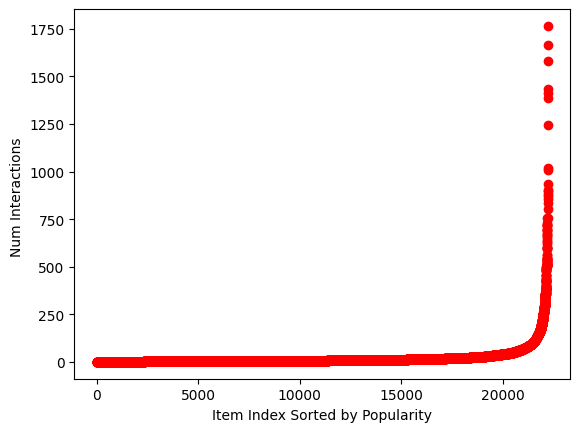

In [105]:
item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity = np.sort(item_popularity)

pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Item Index Sorted by Popularity')
pyplot.show()

In [106]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}\n".format(item_popularity.mean()))
print("Average per-item interactions for the top 10% popular items {:.2f}\n".format(item_popularity[-ten_percent:].mean()))
print("Average per-item interactions for the least 10% popular items {:.2f}\n".format(item_popularity[:ten_percent].mean()))
print("Average per-item interactions for the median 10% popular items {:.2f}\n".format(item_popularity[int(n_items/2-ten_percent/2):int(n_items/2+ten_percent/2)].mean()))

Average per-item interactions over the whole dataset 21.54

Average per-item interactions for the top 10% popular items 122.73

Average per-item interactions for the least 10% popular items 2.35

Average per-item interactions for the median 10% popular items 8.37


In [107]:
print("Number of items with zero interactions {} out of {}".format(np.sum(item_popularity==0), n_items))


Number of items with zero interactions 0 out of 22222


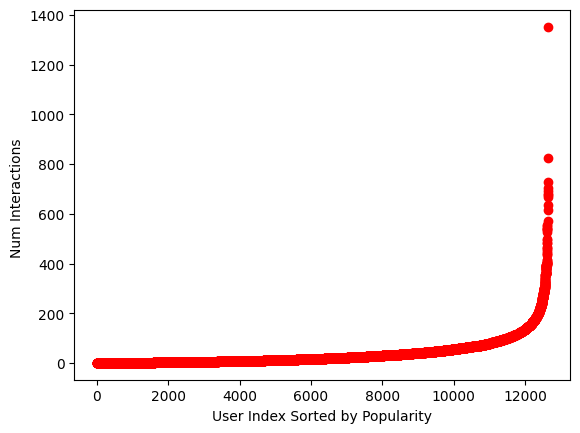

In [108]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)

pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('User Index Sorted by Popularity')
pyplot.show()

In [109]:
train_test_split = 0.8

n_interactions = URM_all.nnz

train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])

In [110]:
URM_all = URM_all.tocoo()
URM_train = sps.csr_matrix((URM_all.data[train_mask], (URM_all.row[train_mask], URM_all.col[train_mask])))

In [111]:
test_mask = np.logical_not(train_mask)
URM_test = sps.csr_matrix((URM_all.data[test_mask], (URM_all.row[test_mask], URM_all.col[test_mask])))

In [112]:
user_id = 124
relevant_items = URM_test[user_id].indices
recommended_items = np.array([241, 1622, 15, 857, 5823])
is_relevant = np.isin(recommended_items, relevant_items, assume_unique=True)

In [113]:
def precision(recommended_items, relevant_items):
    is_relevant = np.isin(recommended_items, relevant_items, assume_unique=True)
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

In [114]:
def recall(recommended_items, relevant_items):
    is_relevant = np.isin(recommended_items, relevant_items, assume_unique=True)
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

In [115]:
def average_precision(recommended_items, relevant_items):
    is_relevant = np.isin(recommended_items, relevant_items, assume_unique=True)
    precision_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    average_precision_score = np.sum(precision_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])
    return average_precision_score

In [122]:
class RandomRecommender(object):
    def __init__(self, users_list):
        self.users_list = users_list
        self.n_items = None
        self.recommendations = {} 
    
    def fit(self, URM_train):
        self.n_items = URM_train.shape[1]
        
    def recommend(self, at=10):
        recommended_items = np.random.choice(self.n_items, at)
        return recommended_items
    
    def generate_submission_csv(self, filename):
        data = []
        for user_id in self.users_list:
            if user_id in self.recommendations:
                recommended_items = self.recommendations[user_id]
                data.append([user_id, " ".join(map(str, recommended_items))])

        submission_df = pd.DataFrame(data, columns=['user_id', 'item_list'])
        submission_df.to_csv(filename, index=False)

In [117]:
def evaluate_algorithm(URM_test, recommender_object, at=5):
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0
    
    URM_test = sps.csr_matrix(URM_test)
    
    for user_id in range(URM_test.shape[0]):
        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        if len(relevant_items)>0:
            recommended_items = recommender_object.recommend(user_id, at=at)
            
            num_eval+=1
            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += average_precision(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender performance is: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(cumulative_precision, cumulative_recall, MAP))

In [118]:
users_file_path = 'data_target_users_test.csv'
test_users = pd.read_csv(filepath_or_buffer=users_file_path,
                                sep=',',
                                engine='python')
test_users.columns = ['UserID']
print(test_users.head(n=20000))
users_list = test_users['UserID'].values
print(users_list)

       UserID
0           1
1           2
2           3
3           4
4           5
...       ...
10877   13020
10878   13021
10879   13022
10880   13023
10881   13024

[10882 rows x 1 columns]
[    1     2     3 ... 13022 13023 13024]


In [123]:
random_recommender = RandomRecommender(users_list)
random_recommender.fit(URM_train)

for user_id in users_list:
    random_recommender.recommend(user_id, at=10)

    random_recommender.generate_submission_csv('submission_random.csv')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/45/5q6zskw54k5crwq2ngs9b_mh0000gn/T/ipykernel_43691/900247670.py", line 7, in <module>
    random_recommender.generate_submission_csv('submission_random.csv')
  File "/var/folders/45/5q6zskw54k5crwq2ngs9b_mh0000gn/T/ipykernel_43691/977540169.py", line -1, in generate_submission_csv
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packag

In [120]:
evaluate_algorithm(URM_test, random_recommender, at=10)

Recommender performance is: Precision = 0.0005, Recall = 0.0007, MAP = 0.0003


In [121]:
print(URM_train)

  (0, 0)	1.0
  (0, 1)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 5)	1.0
  (0, 6)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 10)	1.0
  (0, 11)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 14)	1.0
  (0, 15)	1.0
  (0, 18)	1.0
  (0, 19)	1.0
  (0, 20)	1.0
  (0, 22)	1.0
  (0, 23)	1.0
  (0, 24)	1.0
  (0, 26)	1.0
  (0, 27)	1.0
  (0, 28)	1.0
  (0, 29)	1.0
  :	:
  (12637, 8356)	1.0
  (12637, 8357)	1.0
  (12637, 8440)	1.0
  (12637, 9570)	1.0
  (12637, 9770)	1.0
  (12637, 10771)	1.0
  (12637, 10897)	1.0
  (12637, 10899)	1.0
  (12637, 10910)	1.0
  (12637, 11115)	1.0
  (12637, 11426)	1.0
  (12637, 11823)	1.0
  (12637, 11978)	1.0
  (12637, 13248)	1.0
  (12637, 13249)	1.0
  (12637, 14344)	1.0
  (12637, 16341)	1.0
  (12637, 16585)	1.0
  (12637, 16590)	1.0
  (12637, 16594)	1.0
  (12637, 16595)	1.0
  (12637, 16602)	1.0
  (12637, 17034)	1.0
  (12637, 17581)	1.0
  (12637, 17584)	1.0
